## Libraries and Dependencies

In [1]:
import sys
sys.path.insert(0, './utils/')

import torch
import torch.nn as nn
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [2]:
'''
set number of iterations
'''
n_iter = 10000

In [3]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = torch.device('cpu')

In [4]:
device

device(type='cuda', index=2)

## Physics-informed Neural Networks

In [5]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [6]:
# the physics-guided neural network
class PhysicsInformedNN(nn.Module):
    def __init__(self, X, u, layers, lb, ub):
        
        super().__init__()
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=n_iter, 
            max_eval=n_iter, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
        self.history = []

    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f
    
    def loss_func_data_driven(self):
        u_pred = self.net_u(self.x, self.t)
        loss = torch.mean((self.u - u_pred) ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        self.history.append(loss.item())
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Loss: %e, l1: %.5f, l2: %.5f' % 
                (
                    loss.item(), 
                    self.lambda_1.item(), 
                    torch.exp(self.lambda_2.detach()).item()
                )
            )
        return loss
    
    def loss_func_physics(self):
        f_pred = self.net_f(self.x, self.t)
        loss = torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        self.history.append(loss.item())
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Loss: %e, l1: %.5f, l2: %.5f' % 
                (
                    loss.item(), 
                    self.lambda_1.item(), 
                    torch.exp(self.lambda_2.detach()).item()
                )
            )
        return loss
    
    def train_data_driven(self, nIter):
        self.dnn.train()
        history = []
        for epoch in range(nIter):
            u_pred = self.net_u(self.x, self.t)
            loss = torch.mean((self.u - u_pred) ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            self.history.append(loss.item())
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item(), 
                        torch.exp(self.lambda_2).item()
                    )
                )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func_data_driven)
    
    def train_data_physics(self, nIter):
        # self.dnn.train()
        history = []
        for epoch in range(nIter):
            f_pred = self.net_f(self.x, self.t)
            loss = torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            self.history.append(loss.item())
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item(), 
                        torch.exp(self.lambda_2).item()
                    )
                )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func_physics)
        
    def predict_data_driven(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f
    
    def predict_physics(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Configurations

In [7]:
nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

## Training on Non-noisy Data

In [8]:
'''
Stage I
'''

'\nStage I\n'

In [9]:
%%time

noise = 0.0            

# create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# training
model_DD = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model_DD.train_data_driven(10000)

It: 0, Loss: 4.195e-01, Lambda_1: 0.000, Lambda_2: 0.002479
It: 100, Loss: 8.047e-02, Lambda_1: 0.000, Lambda_2: 0.002479
It: 200, Loss: 2.811e-02, Lambda_1: 0.000, Lambda_2: 0.002479
It: 300, Loss: 1.313e-02, Lambda_1: 0.000, Lambda_2: 0.002479
It: 400, Loss: 9.945e-03, Lambda_1: 0.000, Lambda_2: 0.002479
It: 500, Loss: 6.246e-03, Lambda_1: 0.000, Lambda_2: 0.002479
It: 600, Loss: 3.737e-03, Lambda_1: 0.000, Lambda_2: 0.002479
It: 700, Loss: 2.672e-03, Lambda_1: 0.000, Lambda_2: 0.002479
It: 800, Loss: 2.025e-03, Lambda_1: 0.000, Lambda_2: 0.002479
It: 900, Loss: 1.623e-03, Lambda_1: 0.000, Lambda_2: 0.002479
It: 1000, Loss: 1.309e-03, Lambda_1: 0.000, Lambda_2: 0.002479
It: 1100, Loss: 1.106e-03, Lambda_1: 0.000, Lambda_2: 0.002479
It: 1200, Loss: 8.714e-04, Lambda_1: 0.000, Lambda_2: 0.002479
It: 1300, Loss: 7.222e-04, Lambda_1: 0.000, Lambda_2: 0.002479
It: 1400, Loss: 6.142e-04, Lambda_1: 0.000, Lambda_2: 0.002479
It: 1500, Loss: 5.264e-04, Lambda_1: 0.000, Lambda_2: 0.002479
It: 

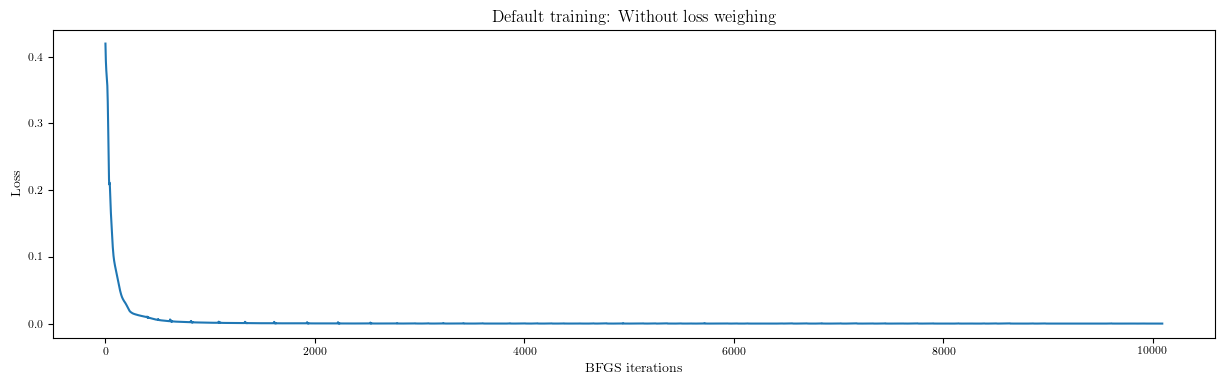

In [10]:
plt.figure(figsize=(15,4))
plt.title("Default training: Without loss weighing")
plt.xlabel("BFGS iterations")
plt.ylabel("Loss")
plt.plot(model_DD.history)

In [11]:
# evaluations
u_pred, f_pred = model_DD.predict_data_driven(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model_DD.lambda_1.detach().cpu().numpy()
lambda_2_value = model_DD.lambda_2.detach().cpu().numpy()
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

Error u: 7.492132e-03
Error l1: 100.00000%
Error l2: 22.12771%


In [12]:
torch.save(model_DD.state_dict(), 'model_data_driven_10k.pth')

In [13]:
'''
Stage II
'''

'\nStage II\n'

In [14]:
modelphy = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
modelphy.load_state_dict(torch.load('model_data_driven_10k.pth'))

<All keys matched successfully>

In [15]:
# modelphy.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
# modelphy.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device)

In [16]:
%%time

noise = 0.0            

# create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# training
modelphy.train_data_physics(10000)

It: 0, Loss: 3.455e+00, Lambda_1: 0.001, Lambda_2: 0.002476
It: 100, Loss: 3.818e-02, Lambda_1: 0.019, Lambda_2: 0.002431
It: 200, Loss: 1.451e-02, Lambda_1: 0.020, Lambda_2: 0.002426
It: 300, Loss: 6.950e-03, Lambda_1: 0.020, Lambda_2: 0.002422
It: 400, Loss: 3.906e-03, Lambda_1: 0.020, Lambda_2: 0.002420
It: 500, Loss: 2.638e-03, Lambda_1: 0.020, Lambda_2: 0.002419
It: 600, Loss: 2.006e-03, Lambda_1: 0.020, Lambda_2: 0.002418
It: 700, Loss: 1.603e-03, Lambda_1: 0.021, Lambda_2: 0.002417
It: 800, Loss: 1.310e-03, Lambda_1: 0.021, Lambda_2: 0.002417
It: 900, Loss: 1.085e-03, Lambda_1: 0.021, Lambda_2: 0.002416
It: 1000, Loss: 9.050e-04, Lambda_1: 0.021, Lambda_2: 0.002415
It: 1100, Loss: 7.592e-04, Lambda_1: 0.021, Lambda_2: 0.002415
It: 1200, Loss: 6.393e-04, Lambda_1: 0.021, Lambda_2: 0.002414
It: 1300, Loss: 5.400e-04, Lambda_1: 0.021, Lambda_2: 0.002414
It: 1400, Loss: 4.574e-04, Lambda_1: 0.021, Lambda_2: 0.002413
It: 1500, Loss: 3.885e-04, Lambda_1: 0.021, Lambda_2: 0.002413
It: 

In [17]:
# evaluations
u_pred, f_pred = modelphy.predict_data_driven(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = modelphy.lambda_1.detach().cpu().numpy()
lambda_2_value = modelphy.lambda_2.detach().cpu().numpy()
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

Error u: 1.041137e+00
Error l1: 97.85362%
Error l2: 24.36492%
